# Import Libs

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# 0. Preparation (Setting the Random State)

In [2]:
rs = min(289456, 274211)
np.random.seed(rs)

# Exercise 1 (Loading and Preparing the Data)
craeting sub_DF `workdf` and removing some random columns and updating

In [3]:
# 1.1 Load the CSV file into a pandas DataFrame
df_tot = pd.read_csv('cla4lsp_customers.csv', sep='\t')

# 1.2 Create a sub-DF workdf with 2/3 of the original dataframe's rows (randomly sampled)
workdf = df_tot.sample(frac=2 / 3, random_state=rs)

# 1.3 hard-code labels and feature
labels = ['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
          'AcceptedCmp5', 'Response', 'Complain', 'Recency']
features = ['Education', 'Marital_Status', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
            'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
columns_to_remove = ['ID', 'Z_CostContact', 'Z_Revenue']
# 1.4 Remove one feature column randomly from spending or purchasing habits
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                    'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
                    'NumCatalogPurchases', 'NumStorePurchases']
col_to_remove = np.random.choice(spending_columns)
columns_to_remove.append(col_to_remove)
print("Random Column to be dropped: ", col_to_remove)
features.remove(col_to_remove)
workdf.drop(columns_to_remove, axis=1, inplace=True)
workdf.info() #for checking the object type of the columns

Random Column to be dropped:  MntSweetProducts
<class 'pandas.core.frame.DataFrame'>
Index: 1493 entries, 335 to 1224
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           1493 non-null   int64  
 1   Education            1493 non-null   object 
 2   Marital_Status       1493 non-null   object 
 3   Income               1476 non-null   float64
 4   Kidhome              1493 non-null   int64  
 5   Teenhome             1493 non-null   int64  
 6   Dt_Customer          1493 non-null   object 
 7   Recency              1493 non-null   int64  
 8   MntWines             1493 non-null   int64  
 9   MntFruits            1493 non-null   int64  
 10  MntMeatProducts      1493 non-null   int64  
 11  MntFishProducts      1493 non-null   int64  
 12  MntGoldProds         1493 non-null   int64  
 13  NumDealsPurchases    1493 non-null   int64  
 14  NumWebPurchases      1493 non-null   int64  

    Since we have missing values in the income column we drop the missing values

In [4]:
# 1.5 Clean the dataset from missing values in the feature columns
workdf.dropna(inplace=True)
workdf.isnull().sum()


Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
dtype: int64

# Exercise 2 (Encoding of Categorical Data)

In [5]:
categorical_columns = list(workdf.select_dtypes(include=['object']).columns)
print("The categorical columns: ",categorical_columns)

The categorical columns:  ['Education', 'Marital_Status', 'Dt_Customer']


In [6]:
for col in categorical_columns:
    unique_values = workdf[col].unique()
    print(f"Number of Unique values in '{col}': {len(unique_values)}")
    if len(unique_values) < 20:
        print(unique_values)


Number of Unique values in 'Education': 5
['Graduation' 'Master' 'PhD' '2n Cycle' 'Basic']
Number of Unique values in 'Marital_Status': 8
['Divorced' 'Together' 'Married' 'Single' 'Widow' 'Alone' 'YOLO' 'Absurd']
Number of Unique values in 'Dt_Customer': 609


1. Education:
>- Suggested Encoding Method: Ordinal Encoding or One-Hot Encoding
>- Reasoning: Since there is an inherent order in the education levels (e.g., "High School" < "Bachelor" < "Master"), we consider using Ordinal Encoding.

2. Marital_Status:
>- Suggested Encoding Method: One-Hot Encoding
>- Reasoning: Marital status typically doesn't have a natural order, making One-Hot Encoding a suitable choice.

3. Dt_Customer:
>- Suggested Encoding Method: Ordinal Encoding (if there's an order) or Feature Engineering
>- Reasoning: Since this column represents dates, encoding methods are a bit different compared to traditional categorical variables. Instead of directly encoding the date, we'll extract useful features from it. Common features to extract include the year, month, day, and potentially others like day of the week.

## Encoding for Dt_Customer:

In [7]:
Xworkdf = workdf[features].copy()
Xworkdf['Dt_Customer'] = pd.to_datetime(Xworkdf['Dt_Customer'], format="%d-%m-%Y")
Xworkdf['Dt_Customer_Year'] = Xworkdf['Dt_Customer'].dt.year
Xworkdf['Dt_Customer_Month'] = Xworkdf['Dt_Customer'].dt.month
Xworkdf['Dt_Customer_Day'] = Xworkdf['Dt_Customer'].dt.day
Xworkdf['Dt_Customer_DayOfWeek'] = Xworkdf['Dt_Customer'].dt.dayofweek

# now that we're done we can drop Dt_Customer
Xworkdf.drop("Dt_Customer", axis=1, inplace=True)
Xworkdf.columns

Index(['Education', 'Marital_Status', 'Year_Birth', 'Income', 'Kidhome',
       'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntGoldProds', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Dt_Customer_Year', 'Dt_Customer_Month', 'Dt_Customer_Day',
       'Dt_Customer_DayOfWeek'],
      dtype='object')

## Encoding for Marital_Status:

In [8]:
categorical_columns = [ 'Marital_Status']

Xworkdf = pd.get_dummies(Xworkdf, columns=categorical_columns)

## Encoding for Education:

In [9]:
#encode the education column as ordinal
education_map = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
Xworkdf['Education'] = Xworkdf['Education'].map(education_map)
features = Xworkdf.columns

Xworkdf.columns

Index(['Education', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Dt_Customer_Year', 'Dt_Customer_Month',
       'Dt_Customer_Day', 'Dt_Customer_DayOfWeek', 'Marital_Status_Absurd',
       'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO'],
      dtype='object')

In [10]:
Xworkdf.head()

,Education,Year_Birth,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntGoldProds,...,Dt_Customer_Day,Dt_Customer_DayOfWeek,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
335,2,1960,62204.0,0,2,317,46,247,151,139,...,12,2,False,False,True,False,False,False,False,False
798,2,1973,73926.0,0,0,627,91,597,159,15,...,2,5,False,False,False,False,False,True,False,False
1707,2,1965,52117.0,0,1,112,10,107,30,20,...,16,3,False,False,False,False,False,True,False,False
999,2,1956,46086.0,0,1,244,8,32,7,50,...,3,6,False,False,True,False,False,False,False,False
1947,3,1974,83891.0,0,1,217,38,350,111,15,...,20,4,False,False,False,True,False,False,False,False


# Exercise 3 (Preprocessing and full-PCA)

## Create two DFs Xworkdf std and Xworksf mmf

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize scalers
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# create a DataFrame with the standardized features
Xworkdf_std = pd.DataFrame(std_scaler.fit_transform(Xworkdf))
Xworkdf_mm = pd.DataFrame(minmax_scaler.fit_transform(Xworkdf))

# Assign column names to the standardized DataFrame
Xworkdf_std.columns = Xworkdf.columns

# Assign column names to the min-max scaled DataFrame
Xworkdf_mm.columns = Xworkdf.columns

## Comparison of the Variances

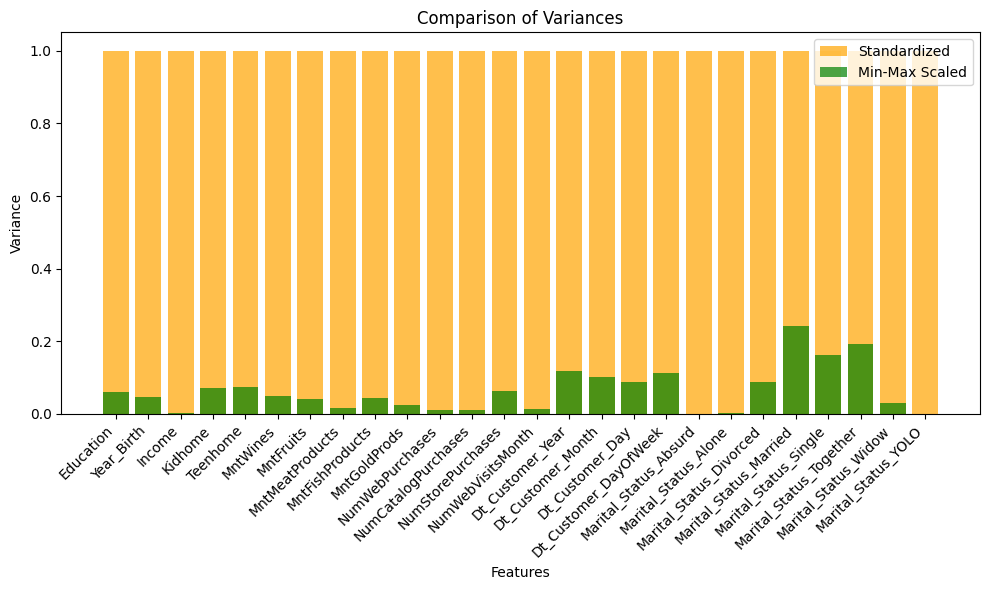

In [12]:

# Calculate variances for each DataFrame
variances_original = Xworkdf.var()
variances_std = Xworkdf_std.var()
variances_mm = Xworkdf_mm.var()

# Plot the variances
plt.figure(figsize=(10, 6))
plt.bar(variances_std.index, variances_std, color='orange', alpha=0.7, label='Standardized')
plt.bar(variances_mm.index, variances_mm, color='green', alpha=0.7, label='Min-Max Scaled')

plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Comparison of Variances')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [13]:
variance_comparison = pd.DataFrame({
    'Original': variances_original,
    'StandardScaler': variances_std,
    'MinMaxScaler': variances_mm
})

# Display the comparison
print(variance_comparison)


                             Original  StandardScaler  MinMaxScaler
Education                9.737081e-01        1.000678      0.060857
Year_Birth               1.339033e+02        1.000678      0.047669
Income                   7.197096e+08        1.000678      0.001628
Kidhome                  2.887267e-01        1.000678      0.072182
Teenhome                 3.015112e-01        1.000678      0.075378
MntWines                 1.115827e+05        1.000678      0.050126
MntFruits                1.599604e+03        1.000678      0.040393
MntMeatProducts          5.099578e+04        1.000678      0.017138
MntFishProducts          2.933021e+03        1.000678      0.043724
MntGoldProds             2.475636e+03        1.000678      0.024026
NumWebPurchases          7.737559e+00        1.000678      0.010614
NumCatalogPurchases      8.905425e+00        1.000678      0.011359
NumStorePurchases        1.059936e+01        1.000678      0.062718
NumWebVisitsMonth        5.665255e+00        1.0

### Analyzing the Variance of across dataframes
01. **Original Data**:
The variances in the "Original" column represent the original distribution of the data before any scaling.
Variances vary significantly across columns, as the scale of the features is different.

2. **MinMaxScaler** (scaling values to a specific range, e.g., $[0, 1]$):
The variance is generally affected. Min-Max Scaling squeezes the data within a fixed interval(in this case $[0,1]$), so the range of values will be smaller, impacting the spread of the data.

3. **Standardscaler** (Z-score Normalization):
Standardscaler centers the data around a mean of $0$ and scales it by the standard deviation. This process does not change the variance, as it maintains the spread of the data relative to its mean.

## Apply the “full” PCA

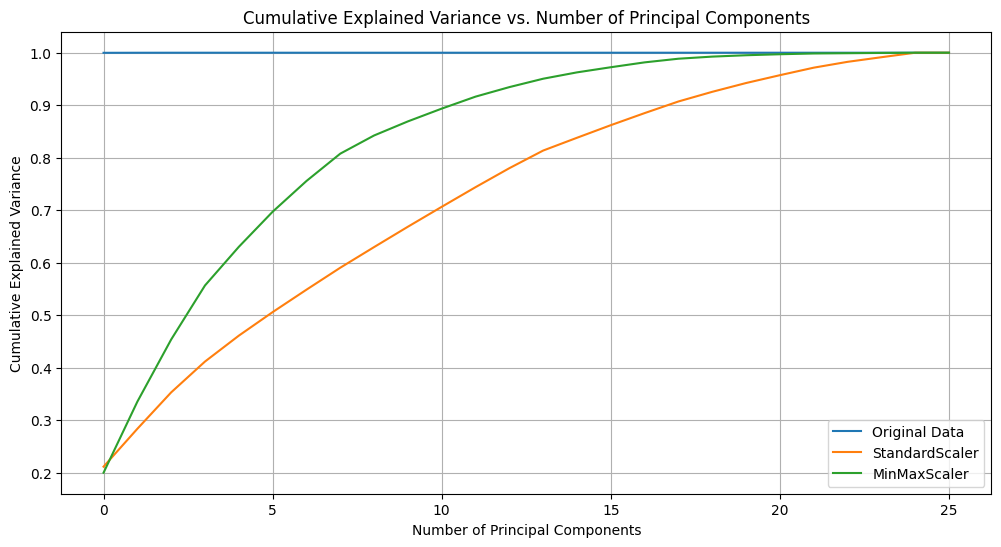

In [19]:
from sklearn.decomposition import PCA

# Initialize PCA for each dataframe
pca_original = PCA()
pca_std = PCA()
pca_mm = PCA()

# Fit and transform the data
_ = pca_original.fit_transform(Xworkdf)
_ = pca_std.fit_transform(Xworkdf_std)
_ = pca_mm.fit_transform(Xworkdf_mm)

# Calculate cumulative explained variance
cumulative_explained_variance_original = np.cumsum(pca_original.explained_variance_ratio_)
cumulative_explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)
cumulative_explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_explained_variance_original, label='Original Data')
plt.plot(cumulative_explained_variance_std, label='StandardScaler')
plt.plot(cumulative_explained_variance_mm, label='MinMaxScaler')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.legend()
plt.show()



1. **Blue Line - Original Data:**
   - The values are extremely close to 1, starting from the very first PC, indicating that almost all the variance in the data is explained by the first principal component.
   - This might suggest that the data has one dominant feature that captures nearly all the information, which could happen if the data points are aligned along one major axis or if there is a strong linear relationship among the features.
   - Since the values are already so close to 1 from the beginning, additional components do not contribute significantly to explaining more variance. The dataset could be effectively reduced to one dimension without losing information.
   - The fact that this line is above the others for any given number of components indicates that the principal components of the original data explain more variance than the principal components of the scaled data.

2. **Green Line - MinMaxScaler:**
   - These values start at approximately 0.20 and gradually increase to 1, indicating that the variance is spread across several components.
   - The more gradual slope suggests that the scaling has distributed the variance such that no single component dominates the explanation of variance. This is more typical of PCA results where multiple components are needed to adequately capture the structure of the data.
   - The cumulative variance reaches 1 at the 25th component, meaning that all components are needed to capture the entire variance of the dataset, which implies that MinMax scaling has preserved the multi-dimensional structure of the data.

3. **Orange Line - StandardScaler:**
   - The cumulative variance for the StandardScaler starts at around 0.21 and similarly increases to 1 by the 25th component.
   - The shape of the curve suggests that while the first component explains a significant portion of the variance, it is less dominant compared to the original data.
   - The need for more components to reach a cumulative variance of 1 indicates that StandardScaler, like MinMaxScaler, has distributed the variance across multiple dimensions of the data.

In summary:

- The original data seems to be characterized by a single, very strong component, which could be due to highly correlated features or a single dominant feature.
- The MinMaxScaler and StandardScaler have normalized the data in such a way that the variance is more evenly spread across the components. This implies that the underlying dimensionality of the scaled data is higher than that of the original data.
- The PCA on scaled data does not show a single dominant feature, as opposed to the original data, which could be beneficial for machine learning applications where we want to avoid features with disproportionate influence on the model.
- For the MinMaxScaler and StandardScaler data, more principal components are required to capture the same amount of information as the original data, which indicates that scaling has the effect of "spreading out" the information across multiple dimensions.

# Exercise 4 (Dimensionality Reduction and Interpretation of the PCs)

Number of PCs for StandardScaler: 3
Number of PCs for MinMaxScaler: 2


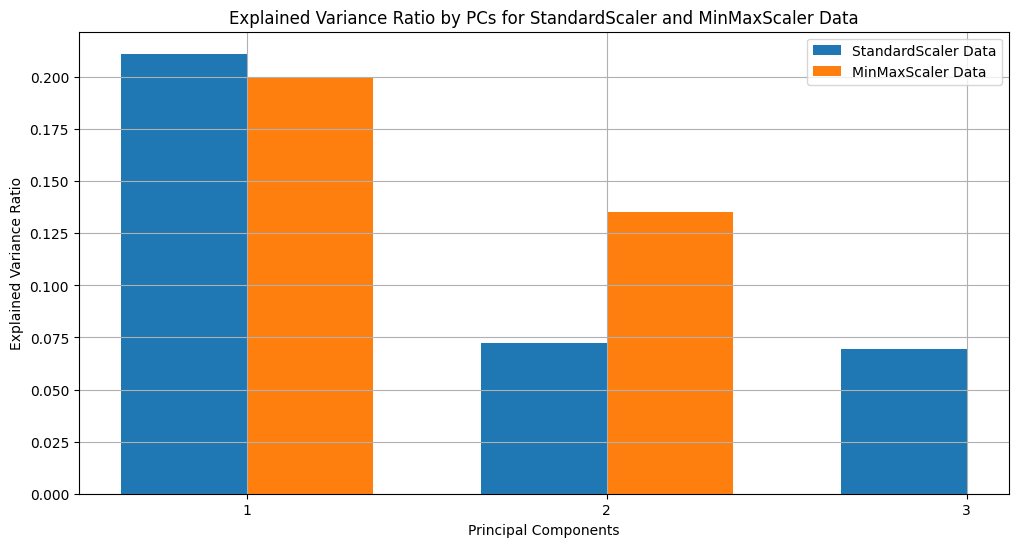

In [22]:
variance_threshold = 0.33

# Determine the number of principal components for StandardScaler data
num_pcs_std = np.argmax(cumulative_explained_variance_std >= variance_threshold) + 1
m_std = min(num_pcs_std, 5)
print(f"Number of PCs for StandardScaler: {m_std}")

# Determine the number of principal components for MinMaxScaler data
num_pcs_mm = np.argmax(cumulative_explained_variance_mm >= variance_threshold) + 1
m_mm = min(num_pcs_mm, 5)
print(f"Number of PCs for MinMaxScaler: {m_mm}")

# Perform PCA with the determined number of PCs
pca_std = PCA(n_components=m_std)
pca_mm = PCA(n_components=m_mm)

# Fit the PCA to the scaled datasets
X_std_pca = pca_std.fit_transform(Xworkdf_std)
X_mm_pca = pca_mm.fit_transform(Xworkdf_mm)

# Get the explained variance ratio for each PC of both PCA fits
explained_variance_ratio_std = pca_std.explained_variance_ratio_
explained_variance_ratio_mm = pca_mm.explained_variance_ratio_

# Plot the bar plots for the percentage of explained variance for each PC
indices_std = np.arange(1, m_std + 1)
indices_mm = np.arange(1, m_mm + 1)

# Set the bar width
bar_width = 0.35

# Plot for StandardScaler data
plt.figure(figsize=(12, 6))
bar1 = plt.bar(indices_std - bar_width / 2, explained_variance_ratio_std, bar_width, label='StandardScaler Data')

# Plot for MinMaxScaler data
bar2 = plt.bar(indices_mm + bar_width / 2, explained_variance_ratio_mm, bar_width, label='MinMaxScaler Data')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by PCs for StandardScaler and MinMaxScaler Data')
plt.xticks(np.arange(1, max(m_std, m_mm) + 1))
plt.legend()
plt.grid()
plt.show()

## Extract Dominant Features and Create a Summary Table

We defined a function called `get_dominant_features` to identify the dominant features for each principal component. The function takes a PCA object, a list of feature names, and an optional parameter specifying the number of top features to consider.<br>
We also created a function called `create_summary_table` to create a summary of the PCA results including the explained variance  and the dominant features for each principal component.

In [27]:
def get_dominant_features(pca, feature_names, num_top_features=10):
    """
    :return: DataFrame with dominant features for each PC
    """
    components = pca.components_ # Access the principal components from the PCA object.
    dominant_features = []

    for i, pc in enumerate(components):
        component_loadings = zip(feature_names, pc)
        sorted_features = sorted(component_loadings, key=lambda x: abs(x[1]), reverse=True)
        top_features = sorted_features[:num_top_features]
        dominant_features.append([f"{feature[0]} ({feature[1]:.2f})" for feature in top_features])

    return pd.DataFrame(dominant_features, index=[f'PC{i + 1}' for i in range(len(components))])


def create_summary_table(pca, dominant_features):
    """
    :return: Summary DataFrame
    """
    explained_variance = [f"{var:.2%}" for var in pca.explained_variance_ratio_]
    summary_df = pd.DataFrame({
        'Principal Component': dominant_features.index,
        'Explained Variance': explained_variance,
        'Dominant Features': dominant_features.values.tolist()
    })
    return summary_df

In [28]:
dominant_features_std = get_dominant_features(pca_std, features)
dominant_features_mm = get_dominant_features(pca_mm, features)

summary_table_std = create_summary_table(pca_std, dominant_features_std)
summary_table_mm = create_summary_table(pca_mm, dominant_features_mm)

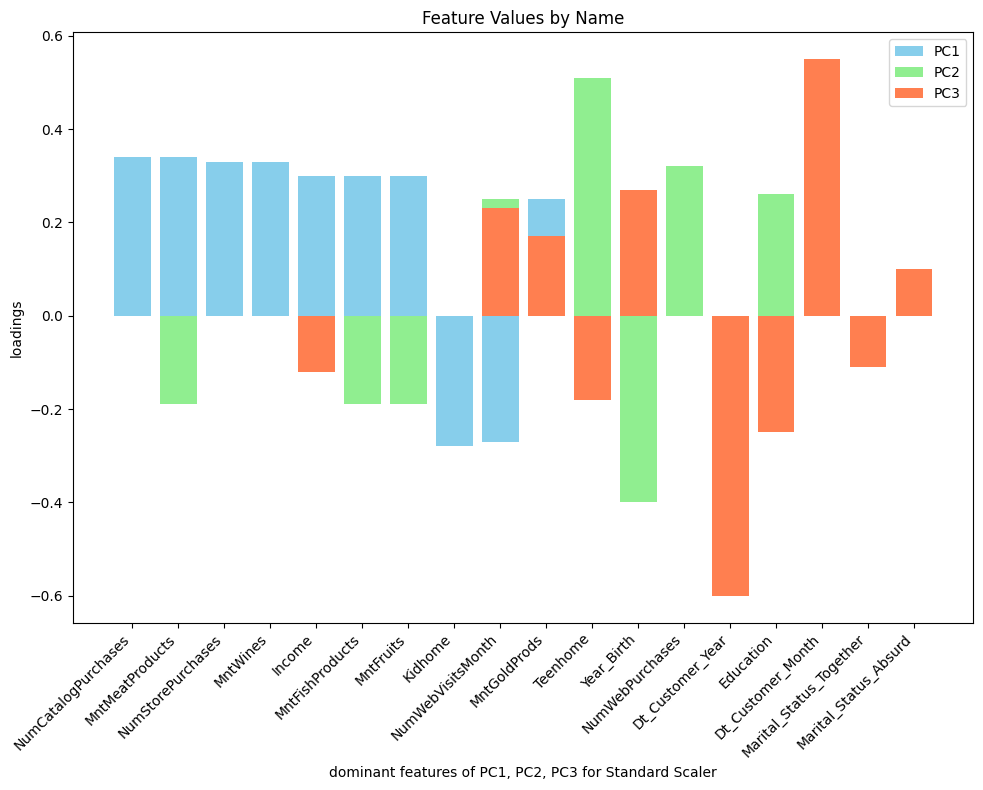

In [50]:
name1 = dominant_features_std.iloc[0,].str.extract(r'^(.*) \(')[0]
values1 = dominant_features_std.iloc[0,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)
name2 = dominant_features_std.iloc[1,].str.extract(r'^(.*) \(')[0]
values2 = dominant_features_std.iloc[1,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)
name3 = dominant_features_std.iloc[2,].str.extract(r'^(.*) \(')[0]
values3 = dominant_features_std.iloc[2,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)


plt.figure(figsize=(10, 8))
bars = plt.bar(name1, values1, color='skyblue', label="PC1") 
bars = plt.bar(name2, values2, color='lightgreen', label="PC2") 
bars = plt.bar(name3, values3, color='coral', label="PC3") 

plt.xlabel('dominant features of PC1, PC2, PC3 for Standard Scaler')
plt.ylabel('loadings')
plt.xticks(rotation=45, ha="right")
plt.title('Feature Values by Name')
plt.legend()
plt.tight_layout()



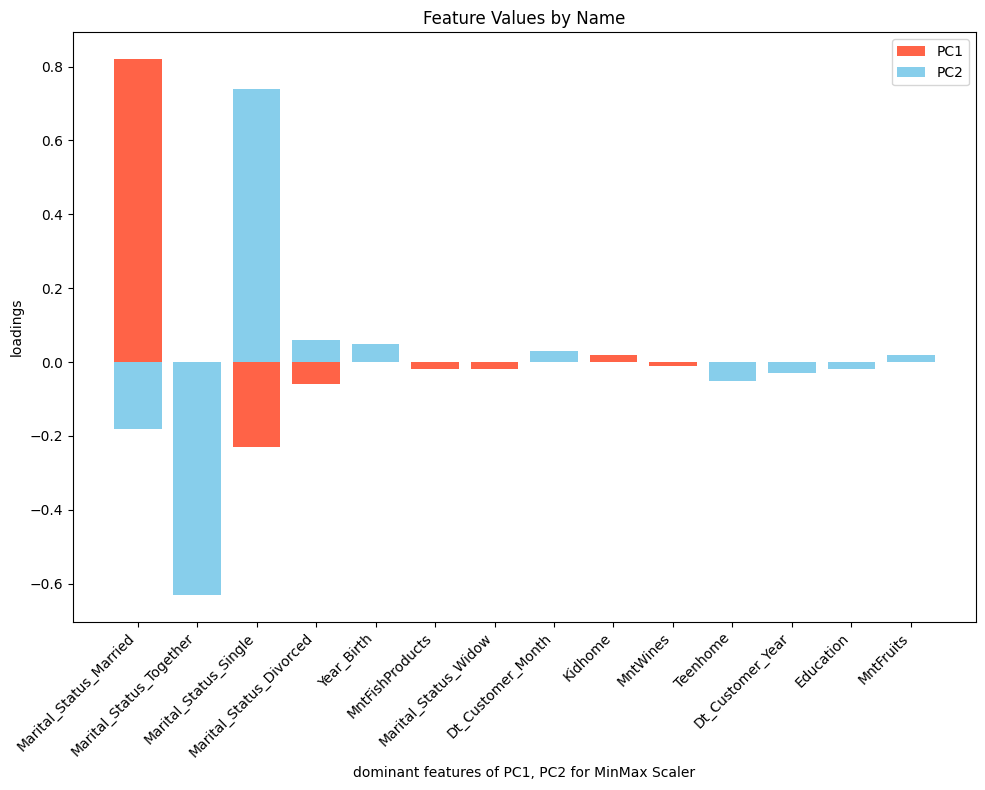

In [66]:
name1 = dominant_features_mm.iloc[0,].str.extract(r'^(.*) \(')[0]
values1 = dominant_features_mm.iloc[0,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)
name2 = dominant_features_mm.iloc[1,].str.extract(r'^(.*) \(')[0]
values2 = dominant_features_mm.iloc[1,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)


plt.figure(figsize=(10, 8))
bars = plt.bar(name1, values1, color='tomato', label="PC1") 
bars = plt.bar(name2, values2, color='skyblue', label="PC2") 


plt.xlabel('dominant features of PC1, PC2 for MinMax Scaler')
plt.ylabel('loadings')
plt.xticks(rotation=45, ha="right")
plt.title('Feature Values by Name')
plt.legend()
plt.tight_layout()

## Interpretation 
To be able to interpret the obtained principal components, we first need to find the high value positive and negative loadings of each principal component.
To find the high values loads of a principle component, we have to take the following steps: 
- After fitting the PCA model, access the components attribute of the model to get the loadings of the principal components. For example `pca.components_[0]` gives the loadings of the first principal component. What we get is an array of loadings for each column (Either positive or negative).
- Then for obtaining the high value loadings, considering the absolute value of the loadings, we sort the array of loadings in descending order and take the first $n$ elements where we consider $n = 10$ of the array. The indices of these elements are the indices of the columns that have the high value loadings for the corresponding principal component.

In [70]:
pd.set_option('display.max_colwidth',None)
summary_table_std

,Principal Component,Explained Variance,Dominant Features
0,PC1,21.12%,"[NumCatalogPurchases (0.34), MntMeatProducts (0.34), NumStorePurchases (0.33), MntWines (0.33), Income (0.30), MntFishProducts (0.30), MntFruits (0.30), Kidhome (-0.28), NumWebVisitsMonth (-0.27), MntGoldProds (0.25)]"
1,PC2,7.21%,"[Teenhome (0.51), Year_Birth (-0.40), NumWebPurchases (0.32), Dt_Customer_Year (-0.27), Education (0.26), NumWebVisitsMonth (0.25), Dt_Customer_Month (0.21), MntFishProducts (-0.19), MntFruits (-0.19), MntMeatProducts (-0.19)]"
2,PC3,6.94%,"[Dt_Customer_Year (-0.60), Dt_Customer_Month (0.55), Year_Birth (0.27), Education (-0.25), NumWebVisitsMonth (0.23), Teenhome (-0.18), MntGoldProds (0.17), Income (-0.12), Marital_Status_Together (-0.11), Marital_Status_Absurd (0.10)]"


### Standard scaler naming:
- As could be seen in the above graphs, for PC1, the most important high values are `NumCatalogPurchases`, `MntMeatProducts`, `NumStorePurchases`so we  can name them as **purchases Group** 
- For PC2 important features are `Teenhome`, `Year_Birth`, `NumWebPurchases`, `Dt_customer_year` we labeled them as **Teens Web Purchases**
- For the PC3 `Dt_Customer_Year`, `Dt_Customer_Month`, `Year_Birth` have high loading and they are labeled as **Enrollment Date**

In [63]:
summary_table_mm

,Principal Component,Explained Variance,Dominant Features
0,PC1,19.97%,"[Marital_Status_Married (0.82), Marital_Status_Together (-0.51), Marital_Status_Single (-0.23), Marital_Status_Divorced (-0.06), Year_Birth (0.03), MntFishProducts (-0.02), Marital_Status_Widow (-0.02), Dt_Customer_Month (0.02), Kidhome (0.02), MntWines (-0.01)]"
1,PC2,13.54%,"[Marital_Status_Single (0.74), Marital_Status_Together (-0.63), Marital_Status_Married (-0.18), Marital_Status_Divorced (0.06), Year_Birth (0.05), Teenhome (-0.05), Dt_Customer_Month (0.03), Dt_Customer_Year (-0.03), Education (-0.02), MntFruits (0.02)]"


### Min_Max scaler naming:
- hight loading PC1 made of `Marital_status_Married`, `Marital_Status_Together`, `Marital_Status_Single` and named as **Marital Status Continuum (+Married -Together -Single)** where on one end, individuals who are married have a high positive score, and on the other end, individuals who are not in a marriage-like relationship (single or together) have lower scores.
- Finally hight loading PC2 made of `Marital_Status_Single`, `Marital_Status_Together`, `Marital_Status_Married` and named as **Single vs. Committed Relationship** 

### Analyzing
The differences in the principal components (PCs) can be seen when using different standardization methods can be attributed to how these methods transform data, their formulas totally different which menthond below:
1. **Standard Scaling**: This scaling is not bounded, meaning the transformed values can have a wide range of values. $mean = 0$ and $std = 1$
$$
Z = \frac{(X - \mu)}{\sigma}
$$

2. **Min-Max Scaling**: This scaling compresses all inliers in the data into the range $[0, 1]$
$$
X_{\text{scaled}} = \frac{(X - X_{\text{min}})}{(X_{\text{max}} - X_{\text{min}})}
$$

The reason why the PCs are different with each standardization method lies in how the data is transformed:
- Standard Scaling sets center around $0$ with  variance $1$. It is more sensitive to variances in different directions in the dataset. If a feature varies widely (even if it's not in the range of the other features), it will influence the PCs.
- Maintains the original distribution of the feature but in a compressed range. It can be more influenced by the range of the features rather than their distribution around the mean.

The numbers associated with each feature in the output for dominant features, like $[NumCatalogPurchases (0.34), MntMeatProducts (0.34)]$, represent the loadings (or coefficients) of the features in the Principal Component (PC). 

In PCA, each original feature contributes to each principal component to a certain degree, which is quantified by these loadings. The loading of a feature in a principal component is a measure of:

1. **Magnitude (Value):** Indicates how strongly the feature influences the principal component. A higher absolute value of the loading means the feature has a stronger influence on the component.
   
2. **Direction (Sign):**
   - A **positive loading** (e.g., $0.34$) suggests that as the feature value increases, the principal component value also increases.
   - A **negative loading** (e.g., $-0.51$) implies that as the feature value increases, the principal component value decreases.

In our example:
- For the first PC, both `NumCatalogPurchases` and `MntMeatProducts` have loadings of approximately $0.34$. This means these features have a similar and positive influence on the first principal component. Their relatively high loading values indicate they are significant contributors to the variance this component captures.
  
- For the second PC, `Dt_Customer_Year` has a positive loading of $0.59$, and `Dt_Customer_Month` has a negative loading of $-0.51$. This means `Dt_Customer_Year` positively influences this component, while `Dt_Customer_Month` influences it in the opposite direction. The magnitude of these loadings suggests they are both important in defining the second principal component.

## PCA Score Plot
When choosing labels for coloring dots in PCA plots, typically we should select features that might explain some of the variance that principal components capture. In other words, we want to choose labels that might have a meaningful relationship with the patterns you're observing in PCA scatter plots.t:

1. **Plot with 'purchases Group', 'Teens Web Purchases', 'Enrollment Date' (Standardized Data):**
   - **'NumDealsPurchases'** could be a good candidate for coloring dots since it directly relates to the number of purchases made. If 'purchases Group' is a component that captures variance related to purchase behavior, this label might show a meaningful pattern.

2. **Plot with 'Marital Status Continuum', 'Single vs. Committed Relationship' (Min-Max Normalized Data):**
   - Since the principal components seem to be capturing information related to marital wetconsider ht want to color they one of the campaign acceptanc', etc.) to see if there's any noticeable trend between marital status and campaign r to do this we create a new column called `CombinedCmp` were it labels in which campaign they participated and if they participated in more than 1 campaign we assignerns you observe.

In [73]:
labels

['NumDealsPurchases',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'Response',
 'Complain',
 'Recency']

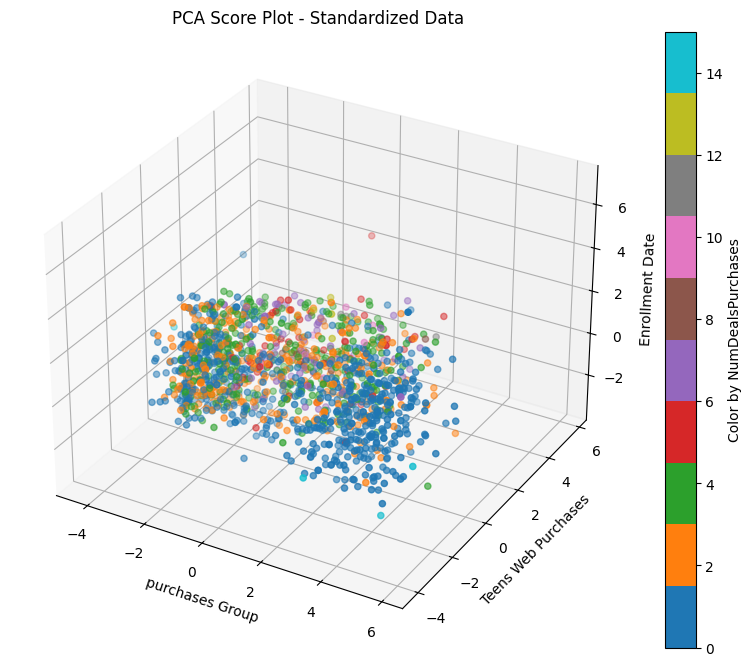

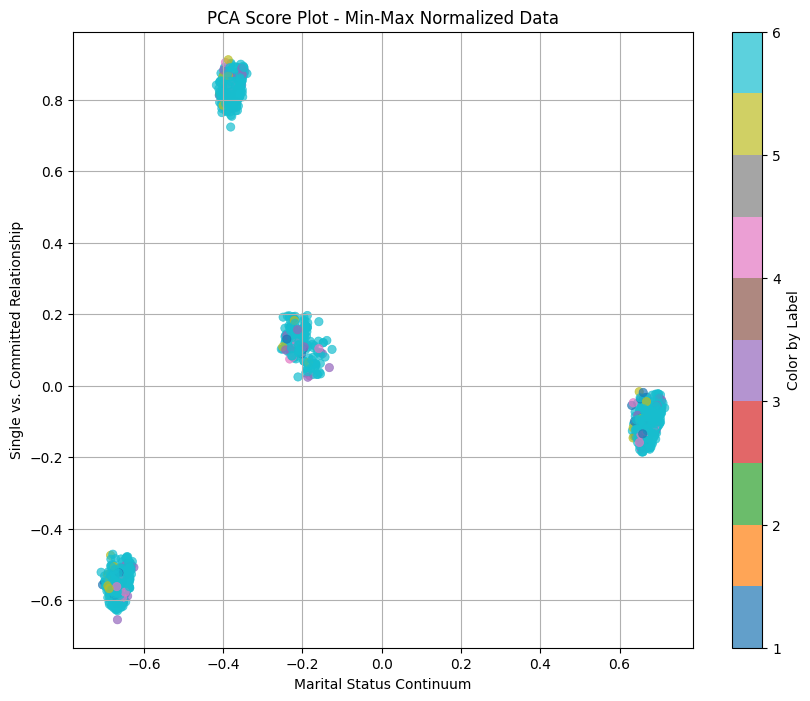

In [111]:
def plot_pca_scores(pca_scores, labels, pc_names, title):
    if len(pc_names) == 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c=labels, alpha=0.7,   
                              linewidth=0.5, cmap='tab10')
    
        plt.xlabel(pc_names[0])
        plt.ylabel(pc_names[1])
        plt.title(title)
        plt.colorbar(scatter, label='Color by Label')
        plt.grid(True)
        plt.show()
    elif len(pc_names) == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(pca_scores[:, 0], pca_scores[:, 1], pca_scores[:, 2], c=labels, cmap='tab10')
        
        ax.set_xlabel(pc_names[0])
        ax.set_ylabel(pc_names[1])
        ax.set_zlabel(pc_names[2])
        ax.set_title(title)
        fig.colorbar(scatter, ax=ax, label='Color by NumDealsPurchases')
        plt.show()
        


plot_pca_scores(X_std_pca,labels= workdf['NumDealsPurchases'], pc_names = ['purchases Group', 'Teens Web Purchases', 'Enrollment Date'],
                title='PCA Score Plot - Standardized Data')
plot_pca_scores(X_mm_pca,labels= workdf['CombinedCmp'], pc_names = ['Marital Status Continuum', 'Single vs. Committed Relationship'],
                  title='PCA Score Plot - Min-Max Normalized Data')

In [108]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'AcceptedCmp1' through 'AcceptedCmp5' are the column names
accepted_cmp_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

# Create a new column 'CombinedCmp' based on the conditions you specified
workdf['CombinedCmp'] = workdf[accepted_cmp_columns].apply(
    lambda row: row[row == 1].index[0].replace('AcceptedCmp', '') if row.sum() == 1 else 6, axis=1
)
workdf['CombinedCmp']


335     6
798     6
1707    6
999     6
1947    6
751     6
1600    6
1056    6
615     6
296     6
1173    4
376     3
888     6
2094    3
1185    6
577     6
367     6
1077    6
348     6
1731    6
1625    6
2231    6
343     6
909     6
669     6
610     6
1256    6
1423    6
1375    6
1671    6
832     6
19      6
1155    6
1534    6
1752    6
1417    6
164     6
503     6
427     6
1299    6
1365    6
795     4
1637    6
1280    5
588     4
13      6
776     6
1760    6
1303    6
215     6
2210    6
1639    6
63      6
820     6
111     4
676     1
1891    6
849     6
1666    6
1758    6
685     6
659     3
1730    6
930     6
2075    6
775     6
711     6
1705    6
636     6
1530    3
2025    6
354     6
500     6
1543    6
1938    6
757     6
176     6
4       6
1617    6
586     6
666     6
1469    6
391     6
846     6
1808    6
1658    6
1842    6
105     6
1170    3
1654    6
110     6
1845    6
1148    6
173     6
695     6
1304    4
581     6
529     6
1231    6
448     6


# Exercise 5 (k-Means)
The term "with respect to the 'PC-space'" refers to performing in the space defined by the Principal Components (PCs) rather than in the original feature space. 

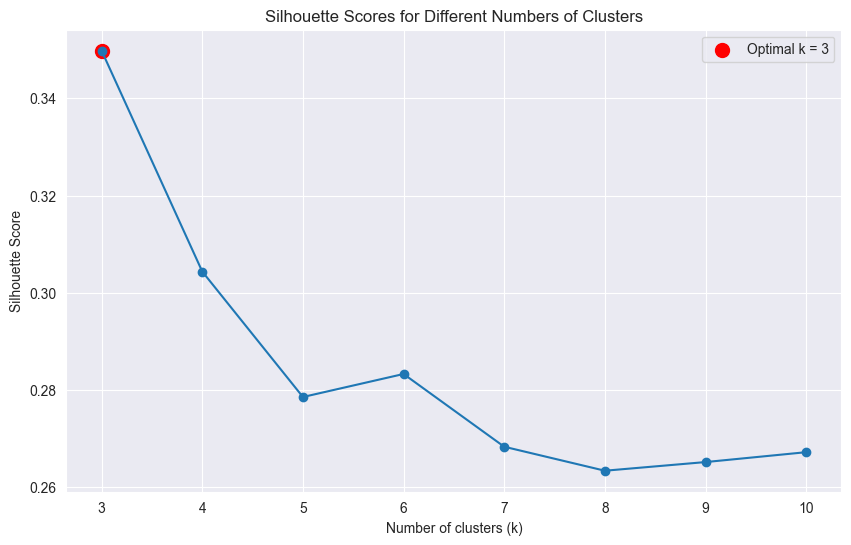

For Standardized Data optimal k is: 3 with Silhouette Score: 0.3498


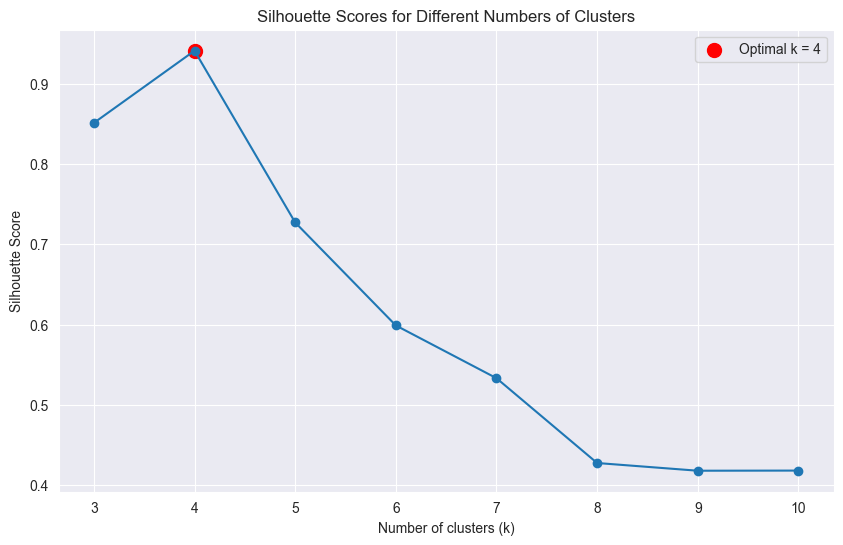

For Min-Max Normalized Data optimal k is: 4 with Silhouette Score: 0.9415


In [23]:
def optimal_k_using_silhouette(pca_data, k_range=range(3, 11)):
    """
    Find the optimal number of clusters (k) using the silhouette coefficient and plot the scores.
    :param pca_data: Data transformed into PCA space
    :param k_range: Range of k values to test
    :return: Optimal k value and silhouette score for optimal k
    """
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=rs, n_init=10)
        cluster_labels = kmeans.fit_predict(pca_data)
        silhouette_avg = silhouette_score(pca_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Determine the optimal number of clusters
    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)

    # Plotting the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.scatter(optimal_k, optimal_score, color='red', s=100, label=f'Optimal k = {optimal_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_k, optimal_score


# Example usage with your PCA-transformed data
std_optimal_k, std_silhouette_score = optimal_k_using_silhouette(X_std_pca)
print(f"For Standardized Data optimal k is: {std_optimal_k} with Silhouette Score: {std_silhouette_score:.4f}")

mm_optimal_k, mm_silhouette_score = optimal_k_using_silhouette(X_mm_pca)
print(f"For Min-Max Normalized Data optimal k is: {mm_optimal_k} with Silhouette Score: {mm_silhouette_score:.4f}")



# Exercise 6 (Clusters and Centroid Interpretation and Visualization)

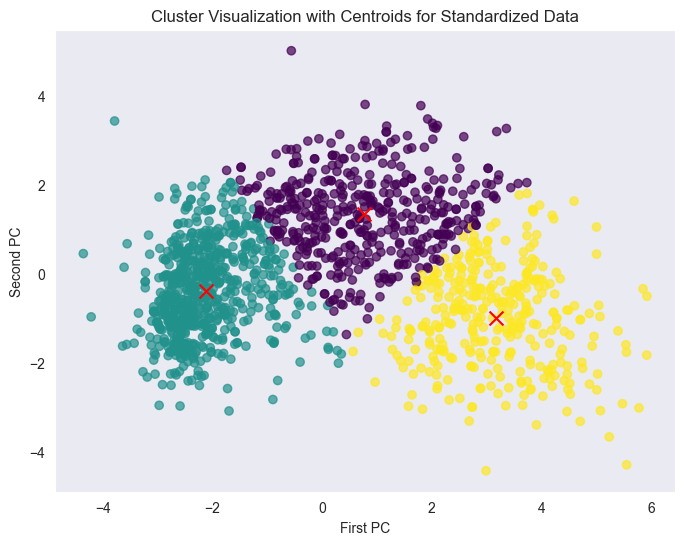

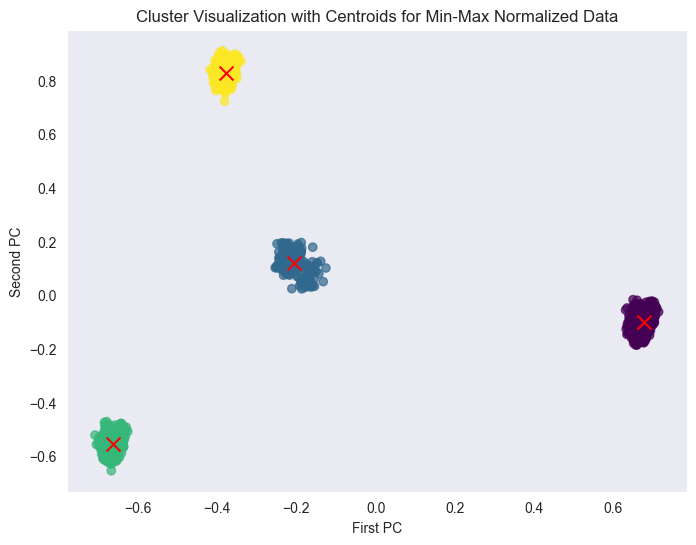

In [24]:
def plot_clusters_and_centroids(pca, kmeans, title):
    """
    Analyze and visualize the centroids of k-means clustering on PCA-transformed data, 
    with data points colored by cluster assignment.
    :param title: the name for the plot
    :param pca: PCA-transformed dataset
    :param kmeans: Trained kMeans object
    """
    # Visualize centroids and data points
    plt.figure(figsize=(8, 6))
    plt.scatter(pca[:, 0], pca[:, 1], alpha=0.7, c=kmeans.labels_, cmap='viridis')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='red')
    plt.xlabel('First PC')
    plt.ylabel('Second PC')
    plt.title('Cluster Visualization with Centroids for {}'.format(title))
    plt.grid()
    plt.show()


kmeans_std = KMeans(n_clusters=std_optimal_k, random_state=rs, n_init=10).fit(X_std_pca)

kmeans_mm = KMeans(n_clusters=mm_optimal_k, random_state=rs, n_init=10).fit(X_mm_pca)

plot_clusters_and_centroids(X_std_pca, kmeans_std, "Standardized Data")

plot_clusters_and_centroids(X_mm_pca, kmeans_mm, "Min-Max Normalized Data")


## Describing the Centroids

### Standardized Data Centroids

In [25]:
num_pcs = summary_table_std.shape[0]
num_centroids = len(kmeans_std.cluster_centers_)

for centroid_index in range(num_centroids):
    print(f"Centroid {centroid_index + 1}:")

    for pc_index in range(num_pcs):
        pc_coord = kmeans_std.cluster_centers_[centroid_index][pc_index]
        explained_variance = summary_table_std['Explained Variance'][pc_index]
        dominant_features = summary_table_std['Dominant Features'][pc_index]

        print(f"\tPC{pc_index + 1}({pc_coord:.4f})")
        print(f"\t\t Explained Variance: {explained_variance}")
        print(f"\t\t Dominant Features: {dominant_features}")


Centroid 1:
	PC1(0.7720)
		 Explained Variance: 21.12%
		 Dominant Features: ['NumCatalogPurchases (0.34)', 'MntMeatProducts (0.34)', 'NumStorePurchases (0.33)', 'MntWines (0.33)', 'Income (0.30)', 'MntFishProducts (0.30)', 'MntFruits (0.30)', 'Kidhome (-0.28)', 'NumWebVisitsMonth (-0.27)', 'MntGoldProds (0.25)']
	PC2(1.3509)
		 Explained Variance: 7.22%
		 Dominant Features: ['Teenhome (0.50)', 'Year_Birth (-0.40)', 'NumWebPurchases (0.32)', 'Dt_Customer_Year (-0.27)', 'Education (0.26)', 'NumWebVisitsMonth (0.24)', 'Dt_Customer_Month (0.22)', 'MntMeatProducts (-0.18)', 'MntFishProducts (-0.18)', 'MntFruits (-0.18)']
	PC3(-0.1294)
		 Explained Variance: 6.94%
		 Dominant Features: ['Dt_Customer_Year (-0.59)', 'Dt_Customer_Month (0.54)', 'Year_Birth (0.28)', 'Education (-0.25)', 'NumWebVisitsMonth (0.23)', 'Teenhome (-0.19)', 'MntGoldProds (0.17)', 'Marital_Status_Together (-0.12)', 'Income (-0.12)', 'Marital_Status_Absurd (0.11)']
Centroid 2:
	PC1(-2.1240)
		 Explained Variance: 21.12

#### Interpretation
- **Dominant Features in PC1:** 'NumCatalogPurchases', 'MntMeatProducts', 'NumStorePurchases' all moderately high.
- **Dominant Features in PC2:** 'Dt_Customer_Year', 'Dt_Customer_Month', 'NumWebVisitsMonth' (suggesting recent engagement and web activity).


##### Centroid 1: "Engaged Recent Web Visitors"
- **PC1 Coordinate (0.6293):** Positive, moderate value in PC1 suggests higher engagement in behaviors captured by PC1's dominant features.
- **PC2 Coordinate (-1.2601):** Strong negative value in PC2, which might indicate characteristics opposite to the positive aspects of PC2's dominant features.


##### Centroid 2: "Less Active, Moderately Recent Customers"
- **PC1 Coordinate (-2.1083):** Strong negative value in PC1 suggests low engagement in PC1's dominant features.
- **PC2 Coordinate (0.3378):** Slightly positive, indicating alignment with PC2's positive aspects but not strongly.


##### Centroid 3: "Highly Engaged, Established Customers"
- **PC1 Coordinate (3.0420):** Very high value in PC1, indicating strong engagement in PC1's dominant features.
- **PC2 Coordinate (0.7104):** Moderately high, aligning with the positive aspects of PC2's dominant features.


##### General Observations:
- **PC1 Dominant Features:** High values in PC1, which has a significant explained variance, suggest strong engagement in catalog purchases, meat products, and store purchases.
- **PC2 Dominant Features:** The interpretation is nuanced by PC2's smaller explained variance, but it seems to relate to customer's recentness and online engagement.

## Min-Max Normalized Data Centroids

In [26]:
num_pcs = summary_table_mm.shape[0]
num_centroids = len(kmeans_mm.cluster_centers_)

for centroid_index in range(num_centroids):
    print(f"Centroid {centroid_index + 1}:")

    for pc_index in range(num_pcs):
        pc_coord = kmeans_mm.cluster_centers_[centroid_index][pc_index]
        explained_variance = summary_table_mm['Explained Variance'][pc_index]
        dominant_features = summary_table_mm['Dominant Features'][pc_index]

        print(f"\tPC{pc_index + 1}({pc_coord:.4f})")
        print(f"\t\t Explained Variance: {explained_variance}")
        print(f"\t\t Dominant Features: {dominant_features}")


Centroid 1:
	PC1(0.6760)
		 Explained Variance: 19.97%
		 Dominant Features: ['Marital_Status_Married (0.82)', 'Marital_Status_Together (-0.51)', 'Marital_Status_Single (-0.23)', 'Marital_Status_Divorced (-0.06)', 'Year_Birth (0.03)', 'MntFishProducts (-0.02)', 'Marital_Status_Widow (-0.02)', 'Dt_Customer_Month (0.02)', 'Kidhome (0.02)', 'MntWines (-0.01)']
	PC2(-0.1015)
		 Explained Variance: 13.54%
		 Dominant Features: ['Marital_Status_Single (0.74)', 'Marital_Status_Together (-0.63)', 'Marital_Status_Married (-0.18)', 'Marital_Status_Divorced (0.06)', 'Year_Birth (0.05)', 'Teenhome (-0.05)', 'Dt_Customer_Month (0.03)', 'Dt_Customer_Year (-0.03)', 'Education (-0.02)', 'MntFruits (0.02)']
Centroid 2:
	PC1(-0.2054)
		 Explained Variance: 19.97%
		 Dominant Features: ['Marital_Status_Married (0.82)', 'Marital_Status_Together (-0.51)', 'Marital_Status_Single (-0.23)', 'Marital_Status_Divorced (-0.06)', 'Year_Birth (0.03)', 'MntFishProducts (-0.02)', 'Marital_Status_Widow (-0.02)', 'Dt_C


#### Interpretation:

##### Centroid 1: "Recent, Family-Oriented Shoppers"
- **PC1 (-0.0678):** Slightly negative, indicating a trend away from characteristics like an earlier customer year and fewer store purchases.
- **PC2 (-0.4695):** Strongly negative, suggesting a recent join year and potentially less engagement (negative value for 'Dt_Customer_Month').

##### Centroid 2: "Moderate, Newly Engaged Customers"
- **PC1 (0.6025):** Positive, indicating alignment with features like earlier customer year and higher store purchases.
- **PC2 (-0.0939):** Slightly negative, pointing towards a more recent customer join date.

##### Centroid 3: "New, Less Active Family Shoppers"
- **PC1 (-0.5226):** Strongly negative, suggesting newer customers with fewer store purchases.
- **PC2 (0.1078):** Slightly positive, indicating a bit older customer join year but still aligning slightly with negative aspects of PC2.

##### Centroid 4: "Established, Regular Buyers"
- **PC1 (0.1698):** Slightly positive, suggesting customers with slightly earlier join years and moderate store purchases.
- **PC2 (0.4808):** Positive, indicating more established customers with fewer recent web visits.

##### Interpretation Logic:
- **Positive PC1 Values:** Indicate alignment with dominant features like earlier customer year and higher store purchases.
- **Negative PC1 Values:** Suggest newer customers or those with lower engagement in store purchases.
- **Positive PC2 Values:** Point towards more established customer relationships.
- **Negative PC2 Values:** Indicate newer customer relationships or less engagement in certain activities like web visits.



# Exercise 7 (Clusters and Centroids Evaluation)

## Internal Evaluation - Silhouette Scores

In [27]:
silhouette_std = silhouette_score(X_std_pca, kmeans_std.labels_)
silhouette_mm = silhouette_score(X_mm_pca, kmeans_mm.labels_)

print(f"Silhouette Score for Standardized Data: {silhouette_std:.4f}")
print(f"Silhouette Score for Min-Max Normalized Data: {silhouette_mm:.4f}")


Silhouette Score for Standardized Data: 0.3498
Silhouette Score for Min-Max Normalized Data: 0.9415


Checking the distribution of labels in dataset:

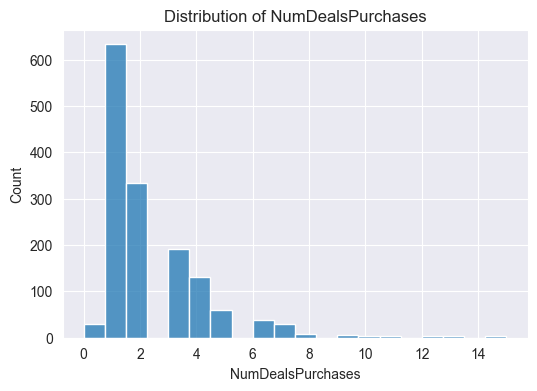

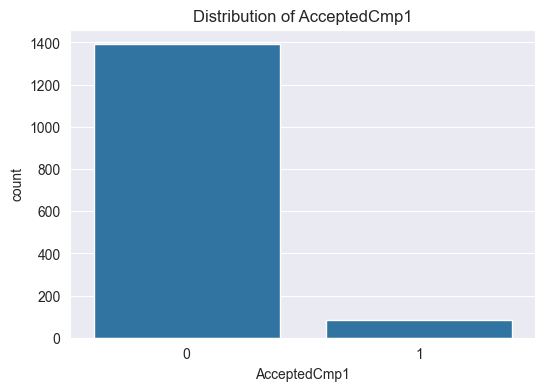

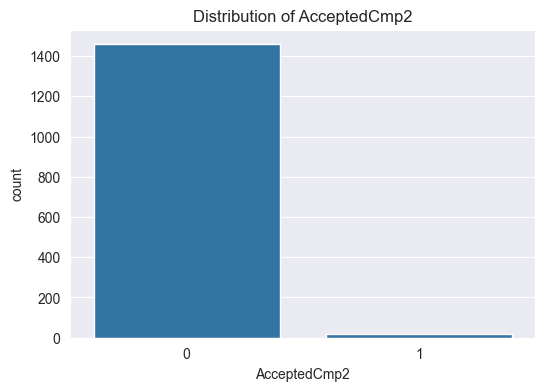

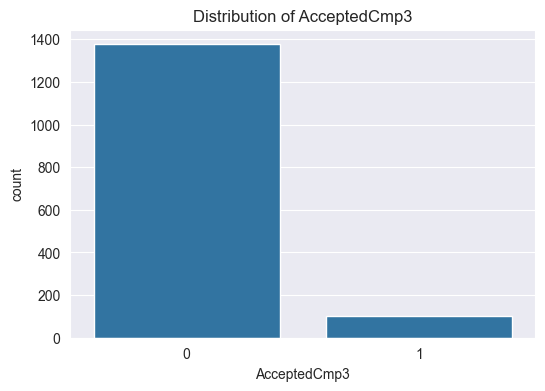

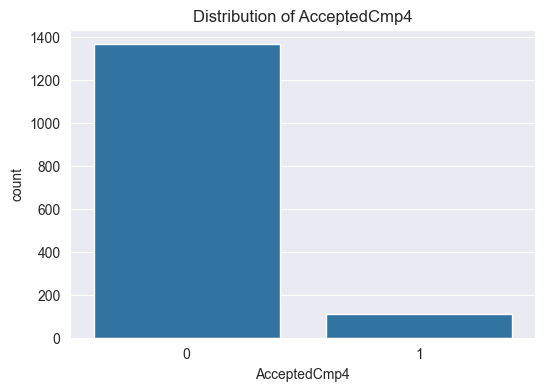

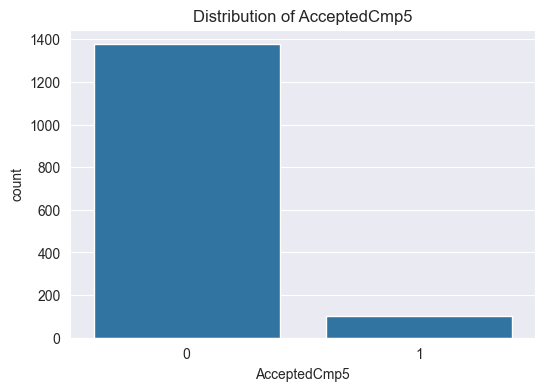

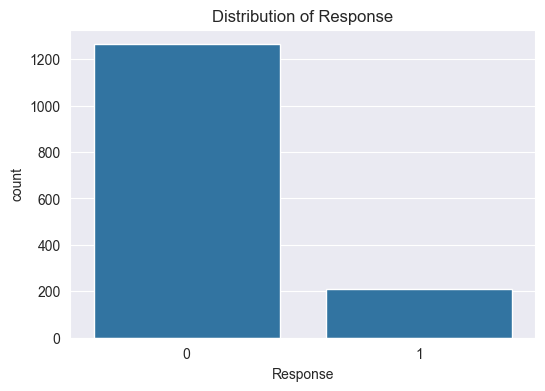

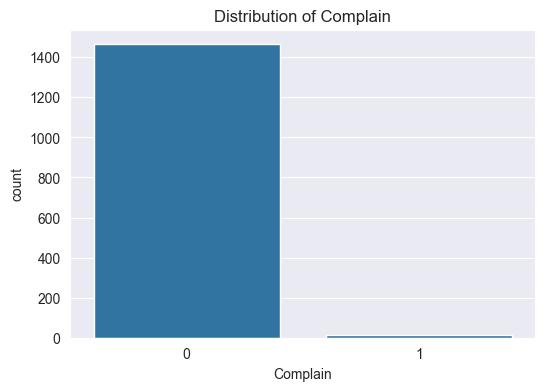

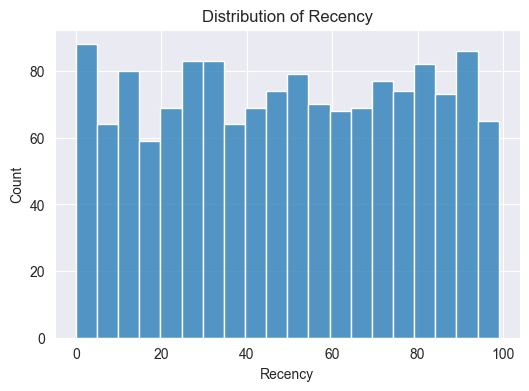

In [28]:
for label in labels:
    plt.figure(figsize=(6, 4))
    if workdf[label].nunique() <= 2:  # For binary labels
        sns.countplot(x=label, data=workdf)
    else:  # For continuous labels
        sns.histplot(workdf[label], bins=20, kde=False)
    plt.title(f'Distribution of {label}')
    plt.show()

Among the shown histograms for each label, the distribution of the 'Recency' label appears to be quite uniform, suggesting that customers' last purchase is fairly evenly spread out over the time frame considered. It can be a meaningful label for external evaluation for several reasons:
-  Customer Engagement: 'Recency' can indicate how recently customers have engaged with the company, which is a key metric in customer relationship management. Recent interactions might suggest more active or engaged customers.

-  Segmentation Relevance: Clusters may differentiate between recent and less recent customers. This can be valuable for targeted marketing campaigns.

-  Behavioral Insight: The behavior of customers with different 'Recency' values within the same cluster may offer insights into the cluster's characteristics.

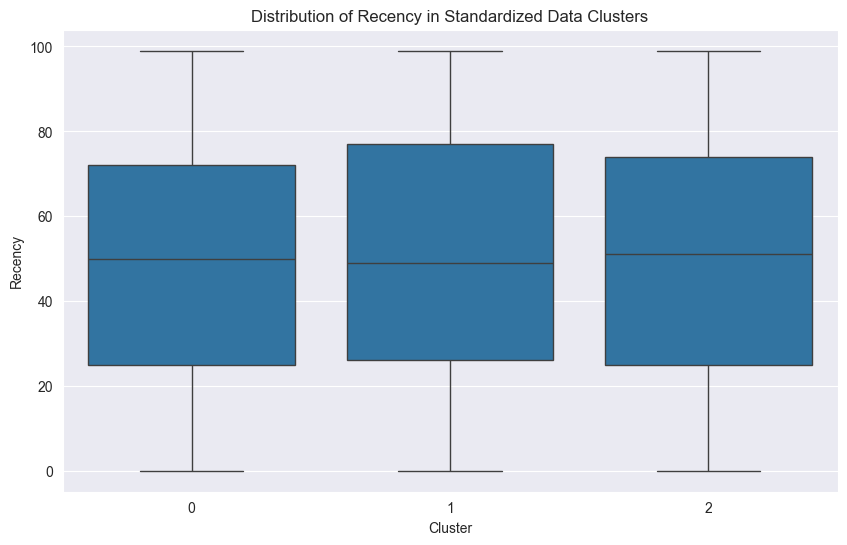

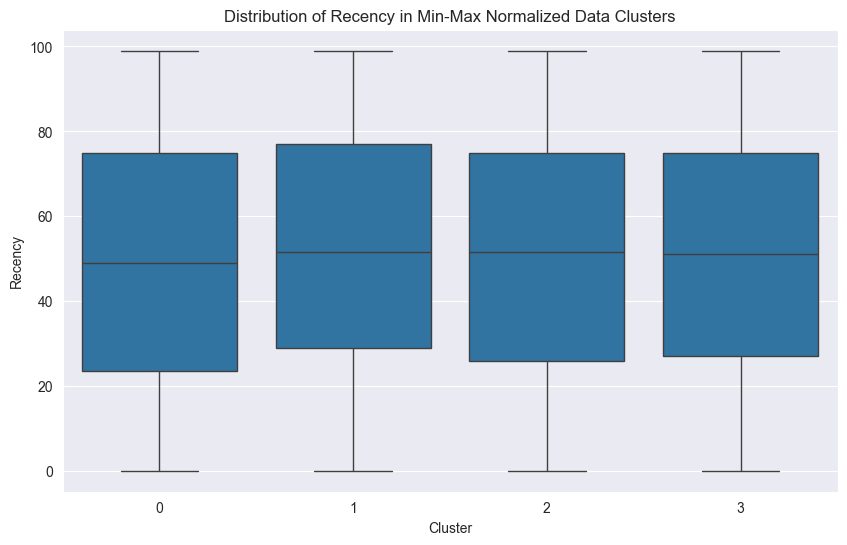

In [29]:
def plot_external_label_distribution(original_df, kmeans_model, label_column, title=''):
    """
    Plot the distribution of a specified label within each cluster.
    :param original_df: Original DataFrame with label_column
    :param kmeans_model: Trained KMeans model
    :param label_column: The name of the column to use for external evaluation
    """
    # Add the cluster assignments to the original DataFrame
    df_with_clusters = original_df.copy()
    df_with_clusters['Cluster'] = kmeans_model.labels_

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=label_column, data=df_with_clusters)
    plt.title(f"Distribution of {label_column} in {title} Clusters")
    plt.xlabel('Cluster')
    plt.ylabel(label_column)
    plt.show()


plot_external_label_distribution(original_df=workdf, kmeans_model=kmeans_std, label_column='Recency',
                                 title="Standardized Data")
plot_external_label_distribution(original_df=workdf, kmeans_model=kmeans_mm, label_column='Recency',
                                 title="Min-Max Normalized Data")


In [30]:
# TODO: Compare the results obtained from Xworkdf_std and Xworkdf_mm and comment them